# Исследование данных сервиса аренды самокатов

Необходимо провести анализ данных сервиса аренды самокатов о некоторых пользователях из нескольких городов, а также об их поездках. 

План работы:

1) проведем предобработку данных;

2) визуализируем данные, исследуем аномалии, если они есть;

3) подсчитаем выручку для пользователей с подпиской и без;

4) проверим гипотезы:
- тратят ли пользователи с подпиской больше времени на поездки?;
- расстояние, которое проезжают пользователи с подпиской за одну поездку, не превышает 3130 метров?;
- будет ли помесячная выручка от пользователей с подпиской по месяцам выше, чем выручка от пользователей без подписки?

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import scipy.stats as st
from scipy.stats import binom, norm
from math import sqrt

## Загрузка данных и изучение общей информации

In [2]:
try:
    data_users = pd.read_csv('/datasets/users_go.csv')
except:
    data_users = pd.read_csv('https://code.s3.yandex.net/datasets/users_go.csv')

In [3]:
try:
    data_rides = pd.read_csv('/datasets/rides_go.csv')
except:
    data_rides = pd.read_csv('https://code.s3.yandex.net/datasets/rides_go.csv')

In [4]:
try:
    data_subscriptions = pd.read_csv('/datasets/subscriptions_go.csv')
except:
    data_subscriptions = pd.read_csv('https://code.s3.yandex.net/datasets/subscriptions_go.csv')

In [5]:
data_users.head() 

,user_id,name,age,city,subscription_type
0,1,Кира,22,Тюмень,ultra
1,2,Станислав,31,Омск,ultra
2,3,Алексей,20,Москва,ultra
3,4,Константин,26,Ростов-на-Дону,ultra
4,5,Адель,28,Омск,ultra


In [6]:
data_users.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1565 entries, 0 to 1564
Data columns (total 5 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   user_id            1565 non-null   int64 
 1   name               1565 non-null   object
 2   age                1565 non-null   int64 
 3   city               1565 non-null   object
 4   subscription_type  1565 non-null   object
dtypes: int64(2), object(3)
memory usage: 61.3+ KB


<div style="border: solid pink 2px; padding: 20px">В таблице data_users 1565 строк, она содержит информацию о уникальном идентификаторе пользователя, его имени, возрасте, город и типе подписки. Нет необходимости менять типы данных, пропусков в таблице нет.

In [7]:
data_rides.head()

,user_id,distance,duration,date
0,1,4409.919140,25.599769,2021-01-01
1,1,2617.592153,15.816871,2021-01-18
2,1,754.159807,6.232113,2021-04-20
3,1,2694.783254,18.511000,2021-08-11
4,1,4028.687306,26.265803,2021-08-28


In [8]:
data_rides.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18068 entries, 0 to 18067
Data columns (total 4 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   user_id   18068 non-null  int64  
 1   distance  18068 non-null  float64
 2   duration  18068 non-null  float64
 3   date      18068 non-null  object 
dtypes: float64(2), int64(1), object(1)
memory usage: 564.8+ KB


<div style="border: solid pink 2px; padding: 20px">В таблице data_rides 18068 строк, она содержит информацию о уникальном идентификаторе пользователя, расстоянии, которое пользователь проехал в текущей сессии (в метрах), продолжительность сессии (в минутах), дате совершения поездки. Необходимо изметить тип данных столбца date на datetime, пропуски отсутствуют.

In [9]:
data_subscriptions

,subscription_type,minute_price,start_ride_price,subscription_fee
0,free,8,50,0
1,ultra,6,0,199


In [10]:
data_subscriptions.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2 entries, 0 to 1
Data columns (total 4 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   subscription_type  2 non-null      object
 1   minute_price       2 non-null      int64 
 2   start_ride_price   2 non-null      int64 
 3   subscription_fee   2 non-null      int64 
dtypes: int64(3), object(1)
memory usage: 192.0+ bytes


<div style="border: solid pink 2px; padding: 20px">В таблице data_subscriptions 2 строки, она содержит информацию о типе подписки, стоимости одной минуты поездки по данной подписке, стоимости начала поездки и стоимости ежемесячного платежа. Пропусков нет, типы данных изменять не нужно.

##  Предобработка данных

### Изменение типов данных

В столбце date таблицы data_rides, указывающем дату совершения поездки, тип данных object заменим на datetime64. 

In [11]:
data_rides['date'] = pd.to_datetime(data_rides['date'], format='%Y-%m-%d')

In [12]:
data_rides.info() # проверим изменение

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18068 entries, 0 to 18067
Data columns (total 4 columns):
 #   Column    Non-Null Count  Dtype         
---  ------    --------------  -----         
 0   user_id   18068 non-null  int64         
 1   distance  18068 non-null  float64       
 2   duration  18068 non-null  float64       
 3   date      18068 non-null  datetime64[ns]
dtypes: datetime64[ns](1), float64(2), int64(1)
memory usage: 564.8 KB


### Создание нового столбца с номером месяца

In [13]:
data_rides['month'] = pd.DatetimeIndex(data_rides['date']).month

In [14]:
data_rides.head() # проверим изменение

,user_id,distance,duration,date,month
0,1,4409.919140,25.599769,2021-01-01,1
1,1,2617.592153,15.816871,2021-01-18,1
2,1,754.159807,6.232113,2021-04-20,4
3,1,2694.783254,18.511000,2021-08-11,8
4,1,4028.687306,26.265803,2021-08-28,8


### Проверка наличия пропущенных значений и дубликатов в датафреймах

Пропущенных значений нет, проверим наличие дубликатов для двух таблиц data_users и data_rides

In [15]:
data_users.duplicated().sum()

31

In [16]:
data_users = data_users.drop_duplicates() # удаление повторяющихся строчек

In [17]:
data_rides.duplicated().sum()

0

## Исследовательский анализ данных

### Частота встречаемости городов

Посмотрим, данные о каких городах исследуем

In [18]:
data_users['city'].unique()

array(['Тюмень', 'Омск', 'Москва', 'Ростов-на-Дону', 'Краснодар',
       'Пятигорск', 'Екатеринбург', 'Сочи'], dtype=object)

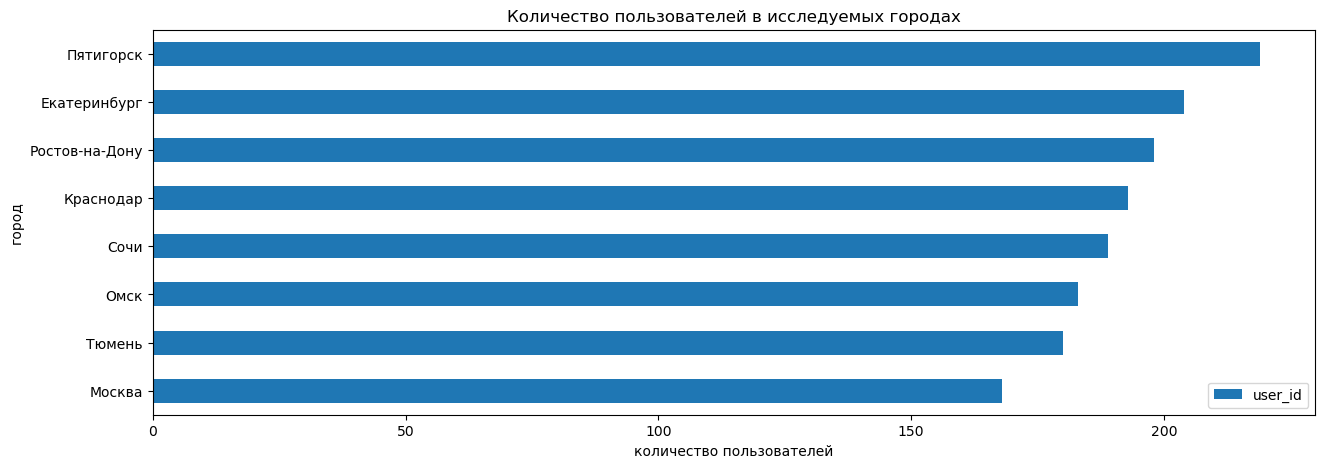

In [19]:
data_users.pivot_table(index='city', values='user_id', aggfunc='count')\
.sort_values(by='user_id', ascending = True)\
.plot(y='user_id', kind='barh', figsize = (15,5), title='Количество пользователей в исследуемых городах')\
.set(xlabel='количество пользователей', ylabel='город');

In [20]:
data_users['city'].value_counts()

Пятигорск         219
Екатеринбург      204
Ростов-на-Дону    198
Краснодар         193
Сочи              189
Омск              183
Тюмень            180
Москва            168
Name: city, dtype: int64

In [21]:
data_users['city'].value_counts(normalize=True) # доли количества пользователей каждого города

Пятигорск         0.142764
Екатеринбург      0.132986
Ростов-на-Дону    0.129074
Краснодар         0.125815
Сочи              0.123207
Омск              0.119296
Тюмень            0.117340
Москва            0.109518
Name: city, dtype: float64

<div style="border: solid pink 2px; padding: 20px">
Доля количества пользователей каждого из восьми городов составляет примерно от 10 до 15%, по графику видно, что больше всего пользователей из Пятигорска (219 пользователей), меньше - из Москвы (168 пользователей).

### Исследуемый период времени

In [22]:
data_rides['date'].min()

Timestamp('2021-01-01 00:00:00')

In [23]:
data_rides['date'].max()

Timestamp('2021-12-30 00:00:00')

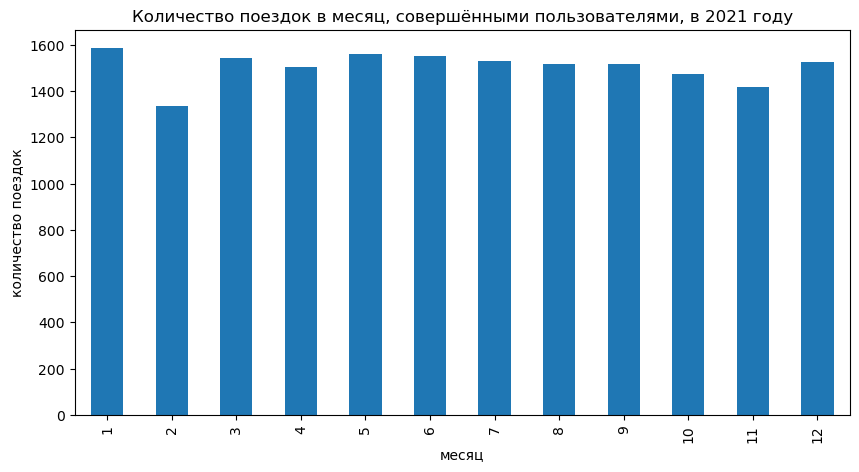

In [24]:
data_rides.groupby('month')['user_id'].count().plot(kind='bar', figsize = (10,5),\
title='Количество поездок в месяц, совершёнными пользователями, в 2021 году')\
.set(xlabel='месяц', ylabel='количество поездок');

In [25]:
(data_rides.groupby('month')['user_id'].count()).median()

1522.5

<div style="border: solid pink 2px; padding: 20px">
Исследуемый период времени - весь 2021 год, кроме 31 декабря 2021 г. Количество поездок для каждого месяца примерно одинаковое, около 1513 поездок. Однако интересно, что в зимний период кикшеринг обычно не доступен, да и передвигаться на самокатах по снегу скорее всего неудобно, с чем должен был быть связан спад на графике.

### Соотношение пользователей с подпиской и без подписки

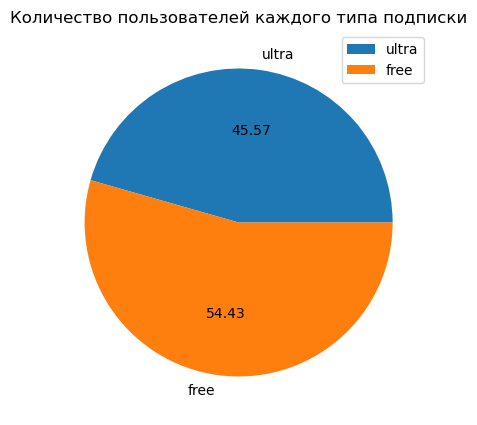

In [26]:
data_users.pivot_table(index='subscription_type', values='user_id', aggfunc='count')\
.sort_values(by='user_id', ascending = True)\
.plot(y='user_id', kind='pie', autopct='%.2f', figsize = (15,5), title='Количество пользователей каждого типа подписки')\
.set(ylabel='');

In [27]:
data_users.pivot_table(index='subscription_type', values='user_id', aggfunc='count')\
.sort_values(by='user_id', ascending = True)

,user_id
subscription_type,
ultra,699
free,835


In [28]:
data_users['subscription_type'].value_counts()

free     835
ultra    699
Name: subscription_type, dtype: int64

In [29]:
data_users['subscription_type'].value_counts(normalize=True)

free     0.544329
ultra    0.455671
Name: subscription_type, dtype: float64

<div style="border: solid pink 2px; padding: 20px">
Количество пользователей без подписки больше (835 пользователей), чем с подпиской (699 пользователей).

### Возраст пользователей

In [30]:
data_users['age'].describe()

count    1534.000000
mean       24.903520
std         4.572367
min        12.000000
25%        22.000000
50%        25.000000
75%        28.000000
max        43.000000
Name: age, dtype: float64

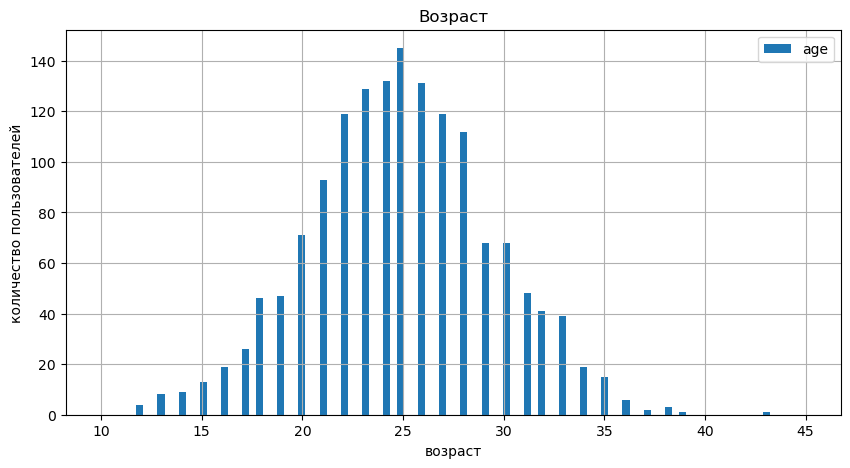

In [31]:
data_users.plot(y='age', kind='hist', bins=100, figsize = (10,5), grid=True, range=(10,45), title='Возраст')\
.set(xlabel='возраст', ylabel='количество пользователей');

<div style="border: solid pink 2px; padding: 20px">Минимальный возраст пользователей - 12 лет, максимальный - 43 года. Средний возраст - 25 лет.

### Расстояние, которое пользователь преодолел за одну поездку

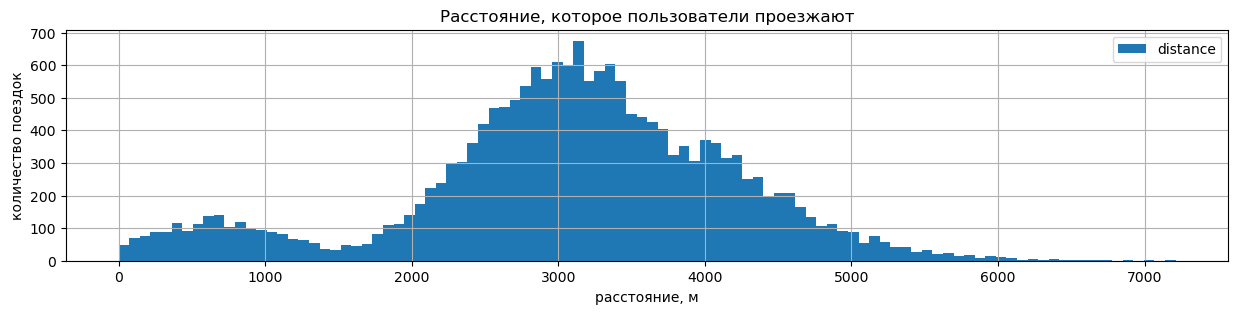

In [32]:
data_rides.plot(y='distance', kind='hist', bins=100, figsize = (15,3), grid=True, title='Расстояние, которое пользователи проезжают')\
.set(xlabel='расстояние, м', ylabel='количество поездок');

In [33]:
data_rides['distance'].describe()

count    18068.000000
mean      3070.659976
std       1116.831209
min          0.855683
25%       2543.226360
50%       3133.609994
75%       3776.222735
max       7211.007745
Name: distance, dtype: float64

<div style="border: solid pink 2px; padding: 20px">
Среднее расстояние, которое проезжает пользователь за одну поездку составляет 3070 м, медианное значение (3133 м) практически не отличается от среднего, что говорит об отсутствии смещения. По графику видим небольшой пик около 500 м, спад около 1500 м и большой пик около среднего значения.

Проверим, как выглядят графики расстояния для разных групп пользователей.Возможно, на короткие расстояния передвигаются пользователи младшего возраста?

In [34]:
data_users_under_20 = data_users.query('age<20')

In [35]:
data_users_under_20_user_id_list = list(data_users_under_20["user_id"])

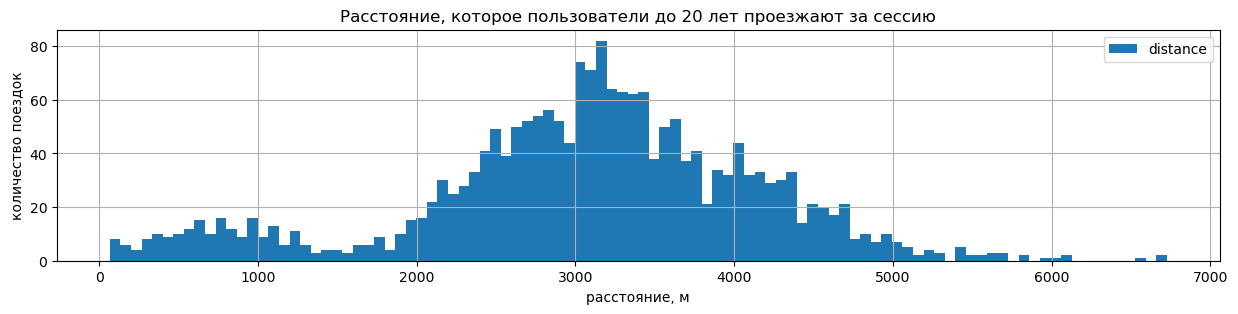

In [36]:
data_rides.query('user_id in @data_users_under_20_user_id_list').plot(y='distance', kind='hist', bins=100, figsize = (15,3), grid=True, title='Расстояние, которое пользователи до 20 лет проезжают за сессию')\
.set(xlabel='расстояние, м', ylabel='количество поездок');

In [37]:
data_users_older_20 = data_users.query('age>20')

In [38]:
data_users_older_20_user_id_list = list(data_users_older_20["user_id"])

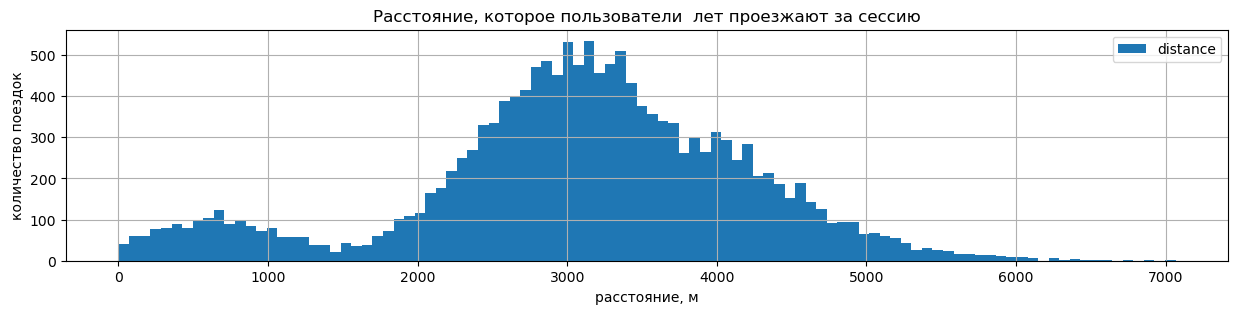

In [39]:
data_rides.query('user_id in @data_users_older_20_user_id_list').plot(y='distance', kind='hist', bins=100, figsize = (15,3), grid=True, title='Расстояние, которое пользователи  лет проезжают за сессию')\
.set(xlabel='расстояние, м', ylabel='количество поездок');

Вид графика расстояния, которое пользователи до 20 лет проезжают за сессии, повторяет вид графика расстояния для всех пользователей, ровно так же, как и график для пользователей за 20 лет. Значит, пик не связан с возрастом.

Проверим связь расстояния и типа подписки пользователей.

In [40]:
data_users_free = data_users.query('subscription_type == "free"')

In [41]:
data_users_free_user_id_list = list(data_users_free["user_id"])

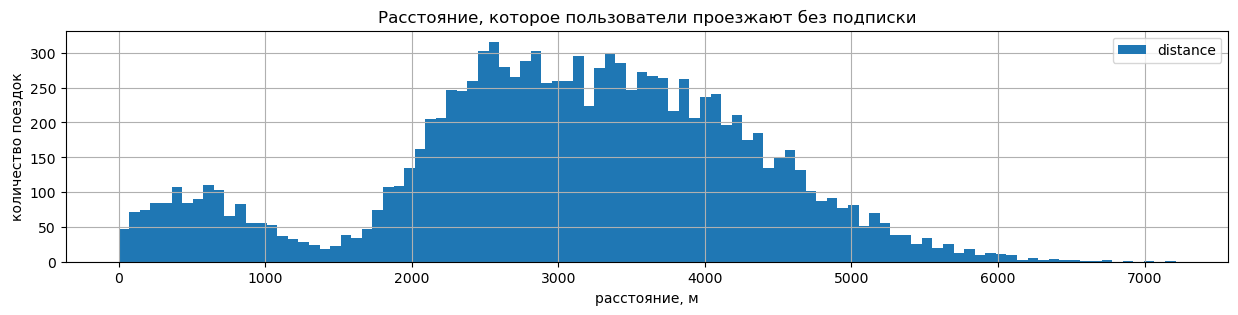

In [42]:
data_rides.query('user_id in @data_users_free_user_id_list').plot(y='distance', kind='hist', bins=100, figsize = (15,3), grid=True, title='Расстояние, которое пользователи проезжают без подписки')\
.set(xlabel='расстояние, м', ylabel='количество поездок');

In [43]:
data_users_ultra = data_users.query('subscription_type == "ultra"')

In [44]:
data_users_ultra_user_id_list = list(data_users_ultra["user_id"])

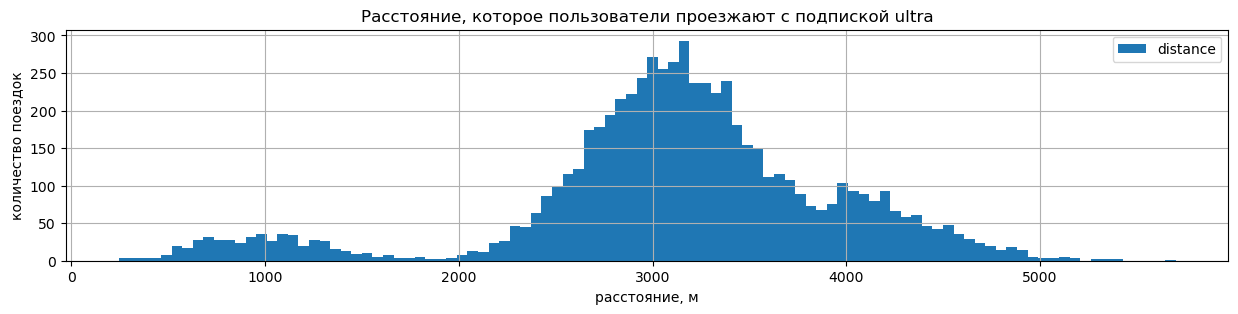

In [45]:
data_rides.query('user_id in @data_users_ultra_user_id_list').plot(y='distance', kind='hist', bins=100, figsize = (15,3), grid=True, title='Расстояние, которое пользователи проезжают с подпиской ultra')\
.set(xlabel='расстояние, м', ylabel='количество поездок');

Графики сходны с общим графиком расстояния, однако можно заметить, что пользователи с подпиской реже ездят на небольшие расстояния, пик около 500 м смещен к 1000 м. Пик на общем графике не связан с подпиской.

Проверим, связано ли расстояние за сессию с городом, в котором находится пользователь.

In [46]:
city_list = data_users.groupby('city')['user_id'].count().index # список городов

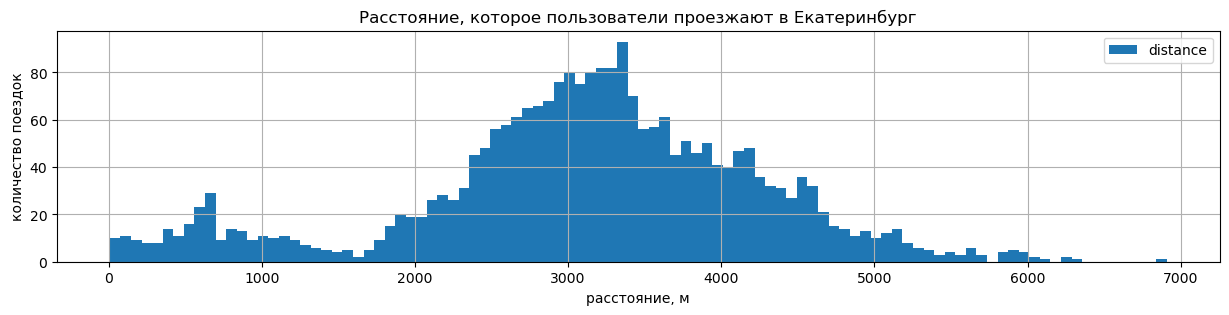

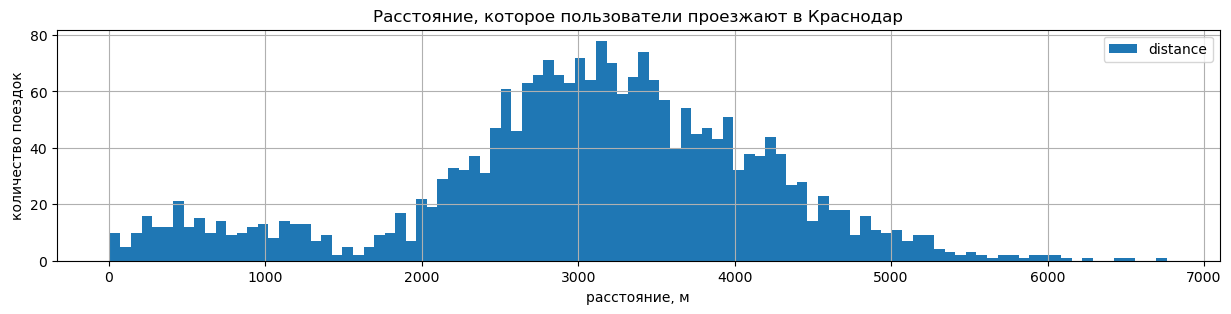

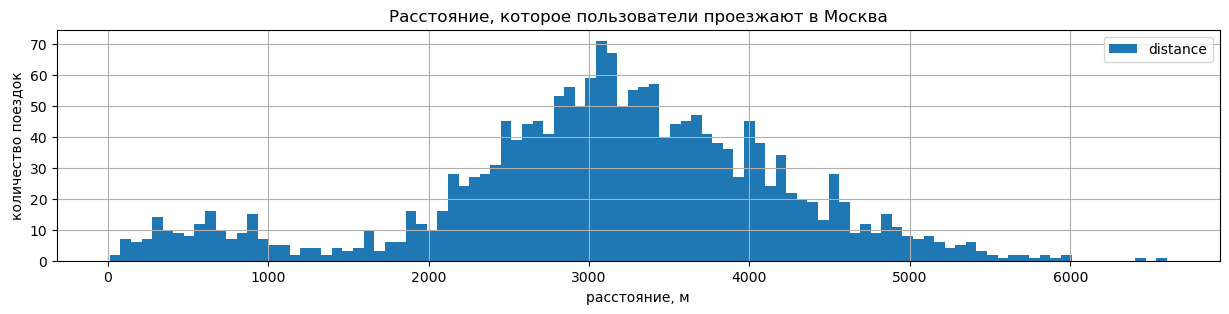

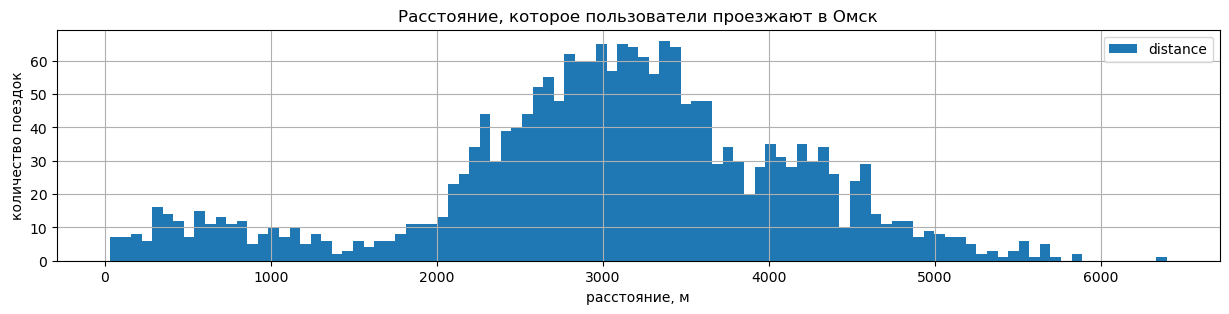

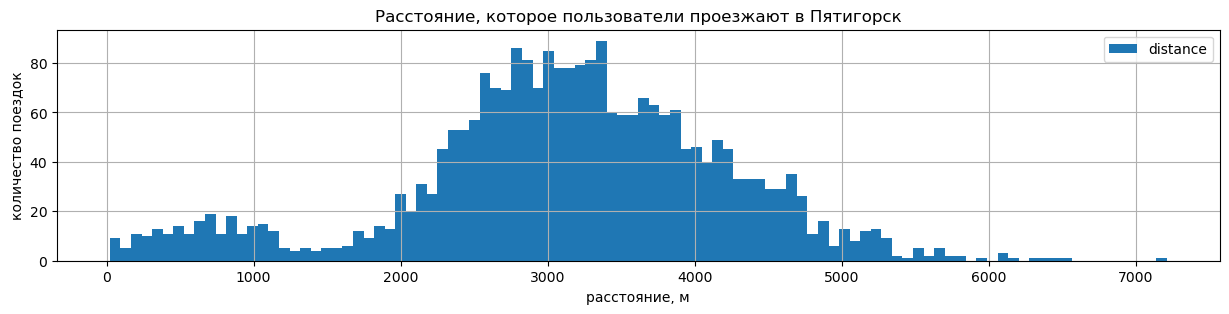

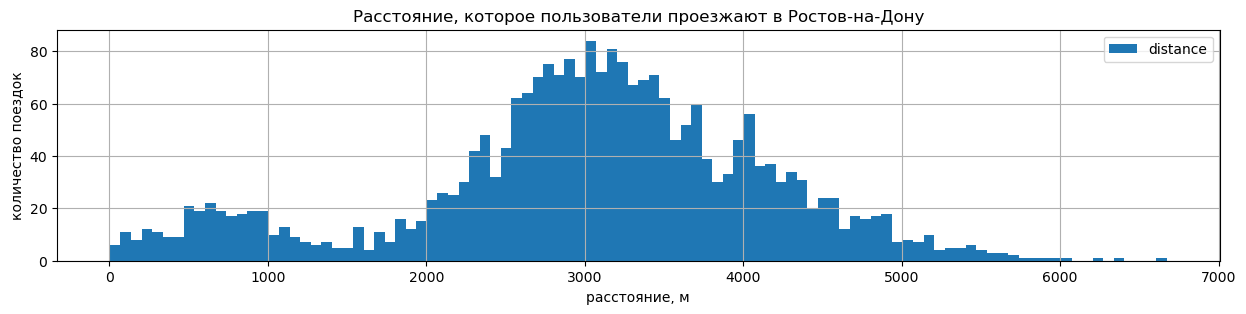

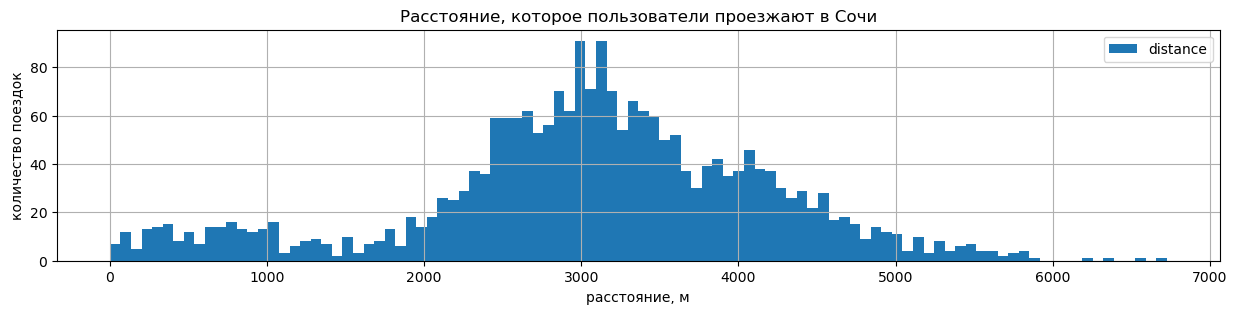

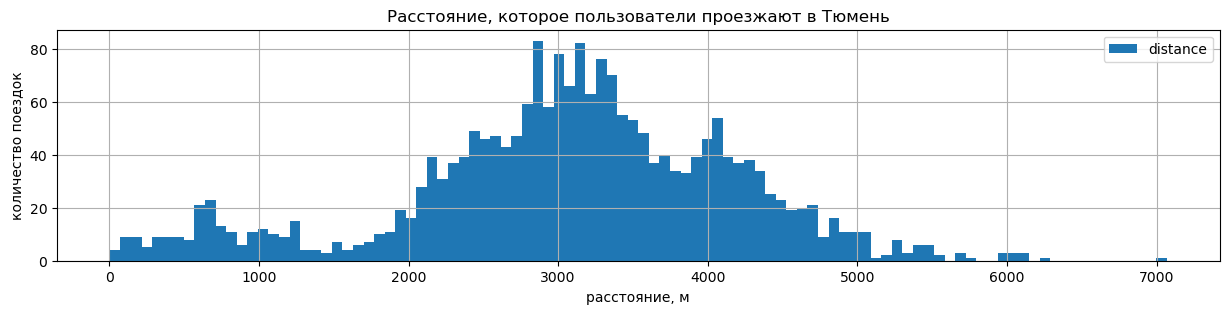

In [47]:
for c in city_list: # для каждого города из списка постороим график
    data_user_city = data_users[data_users['city'] == c]
    data_user_city_user_id_liat = list(data_user_city["user_id"])
    data_rides.query('user_id in @data_user_city_user_id_liat').plot(y='distance', kind='hist', bins=100, figsize = (15,3), grid=True, title=f'Расстояние, которое пользователи проезжают в {c}')\
.set(xlabel='расстояние, м', ylabel='количество поездок');

Графики очень похожи между собой и похожи на общий, поэтому подозревать связь расстояния, которое проезжает пользователь, с городом не будем.

<div style="border: solid pink 2px; padding: 20px">
Очевидно объяснить пик около 500-1000 м не получилось. Возможно, есть часть пользователей передвигается только на небольшие расстояния, а в целом для всех пользователей, расстояние, которое они проезжают, распределено нормально.

### Продолжительность поездок

In [48]:
data_rides['duration'].describe()

count    18068.000000
mean        17.805011
std          6.091051
min          0.500000
25%         13.597563
50%         17.678395
75%         21.724800
max         40.823963
Name: duration, dtype: float64

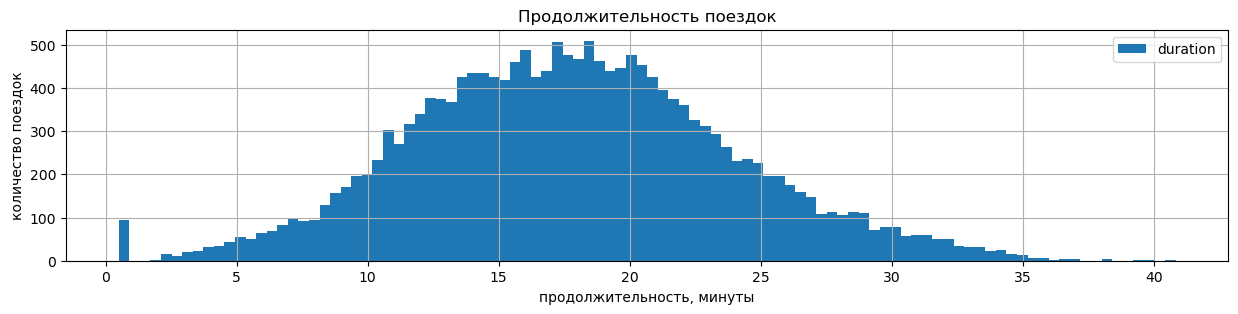

In [49]:
data_rides.plot(y='duration', kind='hist', bins=100, figsize = (15,3), grid=True, title='Продолжительность поездок')\
.set(xlabel='продолжительность, минуты', ylabel='количество поездок');

Виден пик около нуля, посмотрим поближе

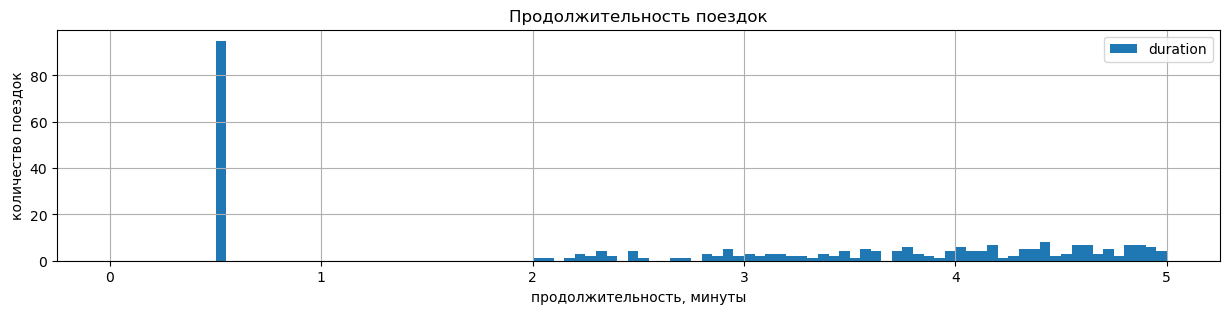

In [50]:
data_rides.plot(y='duration', kind='hist', bins=100, figsize = (15,3), range=(0,5), grid=True, title='Продолжительность поездок')\
.set(xlabel='продолжительность, минуты', ylabel='количество поездок');

Практически сто пользователей закончило поездки за 30 секунд. 

In [51]:
data_rides_30s = data_rides.query('duration < 1')

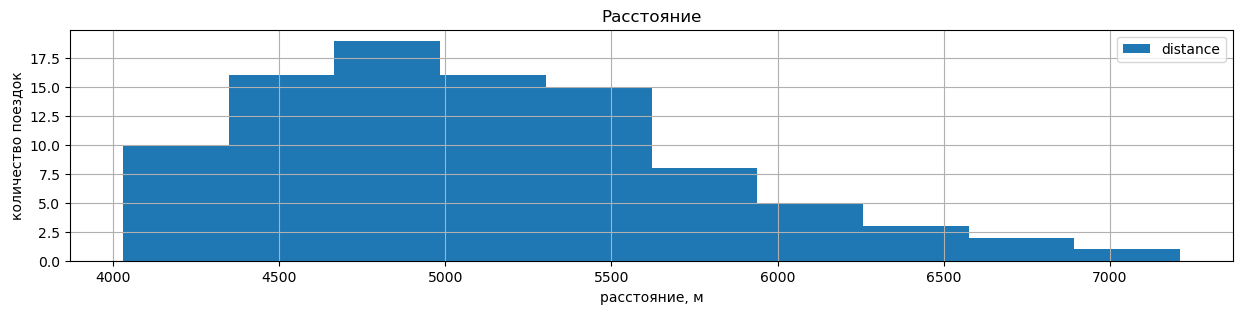

In [52]:
data_rides_30s.plot(y='distance', kind='hist', bins=10, figsize = (15,3), grid=True, title='Расстояние')\
.set(xlabel='расстояние, м', ylabel='количество поездок');

Для поездок, закончившихся за 30 секунд, подозрительно большое расстояние, возможно, произошел сбой про записи продолжительности поездки. 

In [53]:
data_rides_30s_user_id_list = list(data_rides_30s["user_id"])

In [54]:
data_users.query('user_id in @data_rides_30s_user_id_list')['subscription_type'].value_counts() 

free    90
Name: subscription_type, dtype: int64

In [55]:
data_users.query('user_id in @data_rides_30s_user_id_list')['city'].value_counts() 

Ростов-на-Дону    17
Москва            13
Пятигорск         11
Сочи              11
Краснодар         10
Омск              10
Екатеринбург       9
Тюмень             9
Name: city, dtype: int64

Интересно, что сбой записи времени произошел только у пользователей без подписки, однако затронул все исследуемые города.

In [56]:
data_rides['duration'].describe()

count    18068.000000
mean        17.805011
std          6.091051
min          0.500000
25%         13.597563
50%         17.678395
75%         21.724800
max         40.823963
Name: duration, dtype: float64

<div style="border: solid pink 2px; padding: 20px">

- Явных аномалий на графике продолжительности не видно, что подтверждается близостью среднего значения к медианному. Минимальное время поездки составляет около 2 минут, максимальное - 40 минут. 
- Выявили поездки, закончившиеся за 30 секунд, с подозрительно большим расстоянием, возможно, произошел сбой про записи продолжительности поездки. Сбой записи времени произошел только у пользователей без подписки, однако затронул все исследуемые города.

## Объединение данных

In [57]:
data_rides = data_rides.merge(data_users, on='user_id')

In [58]:
data = data_rides.merge(data_subscriptions, on='subscription_type')

In [59]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 18068 entries, 0 to 18067
Data columns (total 12 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   user_id            18068 non-null  int64         
 1   distance           18068 non-null  float64       
 2   duration           18068 non-null  float64       
 3   date               18068 non-null  datetime64[ns]
 4   month              18068 non-null  int64         
 5   name               18068 non-null  object        
 6   age                18068 non-null  int64         
 7   city               18068 non-null  object        
 8   subscription_type  18068 non-null  object        
 9   minute_price       18068 non-null  int64         
 10  start_ride_price   18068 non-null  int64         
 11  subscription_fee   18068 non-null  int64         
dtypes: datetime64[ns](1), float64(2), int64(6), object(3)
memory usage: 1.8+ MB


In [60]:
data.duplicated().sum()

0

### Создание датафреймов 

#### c данными о пользователях без подписки

In [61]:
data_users_free = data.query('subscription_type=="free"')

In [62]:
data_users_free.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 11568 entries, 6500 to 18067
Data columns (total 12 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   user_id            11568 non-null  int64         
 1   distance           11568 non-null  float64       
 2   duration           11568 non-null  float64       
 3   date               11568 non-null  datetime64[ns]
 4   month              11568 non-null  int64         
 5   name               11568 non-null  object        
 6   age                11568 non-null  int64         
 7   city               11568 non-null  object        
 8   subscription_type  11568 non-null  object        
 9   minute_price       11568 non-null  int64         
 10  start_ride_price   11568 non-null  int64         
 11  subscription_fee   11568 non-null  int64         
dtypes: datetime64[ns](1), float64(2), int64(6), object(3)
memory usage: 1.1+ MB


#### с данными о пользователях с подпиской

In [63]:
data_users_ultra = data.query('subscription_type=="ultra"')

In [64]:
data_users_ultra.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 6500 entries, 0 to 6499
Data columns (total 12 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   user_id            6500 non-null   int64         
 1   distance           6500 non-null   float64       
 2   duration           6500 non-null   float64       
 3   date               6500 non-null   datetime64[ns]
 4   month              6500 non-null   int64         
 5   name               6500 non-null   object        
 6   age                6500 non-null   int64         
 7   city               6500 non-null   object        
 8   subscription_type  6500 non-null   object        
 9   minute_price       6500 non-null   int64         
 10  start_ride_price   6500 non-null   int64         
 11  subscription_fee   6500 non-null   int64         
dtypes: datetime64[ns](1), float64(2), int64(6), object(3)
memory usage: 660.2+ KB


<div style="border: solid pink 2px; padding: 20px">
Объединенная таблица data содержит 18068 записей о поездаках каждого пользователя, тип подписки, стоимость начала поездки, минуты и помесячный тариф. Таблица data_users_free содержит 11568 записей только о поездках пользователей без подписки, а таблица data_users_ultra содержит 6500 записей с поездками всех пользователей с подпиской. Пропусков и дубликатов в основной таблице не обнаружено.
    

### Визуализация информации о расстоянии и времени поездок для пользователей с подпиской и без

#### расстояние

In [65]:
data_users_free['distance'].describe()

count    11568.000000
mean      3045.495282
std       1246.173806
min          0.855683
25%       2366.562689
50%       3114.648465
75%       3905.697894
max       7211.007745
Name: distance, dtype: float64

In [66]:
data_users_ultra['distance'].describe()

count    6500.000000
mean     3115.445388
std       836.895330
min       244.210438
25%      2785.444017
50%      3148.637229
75%      3560.574425
max      5699.769662
Name: distance, dtype: float64

<div style="border: solid pink 2px; padding: 20px">
Для пользователей с подпиской среднее расстояние составляет 3115 м, минимальное - около 244 м, максимальное - 5699 м. Для пользователей без подписки среднее расстояние составляет 3028 м, минимальное - около 1 м, максимальное - 7066 м. Количество поездок с подпиской - 6500, без - 11473.

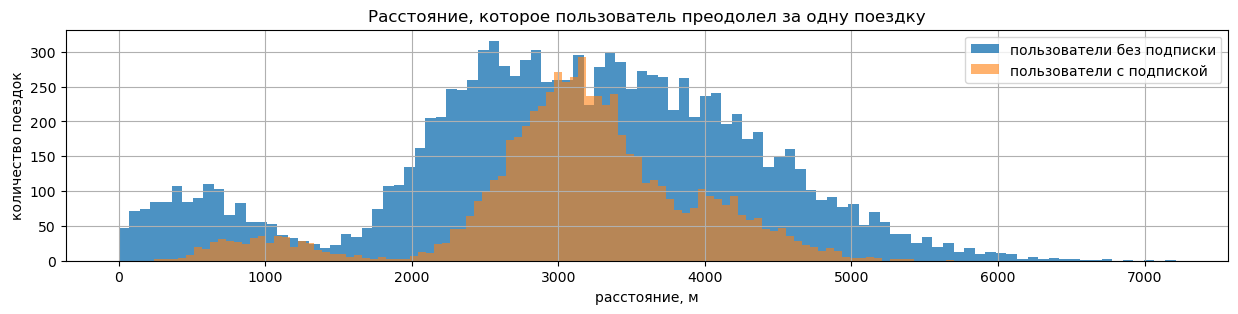

In [67]:
plt.figure(figsize=(15,3))
plt.hist(data_users_free['distance'], bins=100, alpha = 0.8, label='пользователи без подписки')
plt.hist(data_users_ultra['distance'], bins=100, alpha = 0.6, label='пользователи с подпиской')
plt.xlabel('расстояние, м')
plt.ylabel("количество поездок")
plt. grid()
plt.title("Расстояние, которое пользователь преодолел за одну поездку")
plt.legend(loc='upper right');
plt.show()

<div style="border: solid pink 2px; padding: 20px">
Формы графиков напоминают общий график для расстояния, которое проезжает пользователь, однако для пользователей с подпиской первый пик смещен к 1000 м, в то время как для пользователей без подписки он находится около 500 м. Пик графика расстояний пользователей без подписки растянут в сторону больших расстояний, пик графика расстояний пользователей с подпиской более выраженный около среднего значения.

#### время поездки

In [68]:
data_users_free['duration'].describe()

count    11568.000000
mean        17.390909
std          6.326803
min          0.500000
25%         12.958437
50%         17.326890
75%         21.594071
max         34.948498
Name: duration, dtype: float64

In [69]:
data_users_ultra['duration'].describe()

count    6500.000000
mean       18.541985
std         5.572048
min         3.760353
25%        14.524654
50%        18.178153
75%        21.884129
max        40.823963
Name: duration, dtype: float64

<div style="border: solid pink 2px; padding: 20px">

Для пользователей с подпиской среднее время поездки 18 минут, минимальное - 3 минуты, максимальное - 40 минут. Для пользователей без подписки среднее время поездки 17 минут, минимальное - 2 минуты, максимальное - 35 минут.

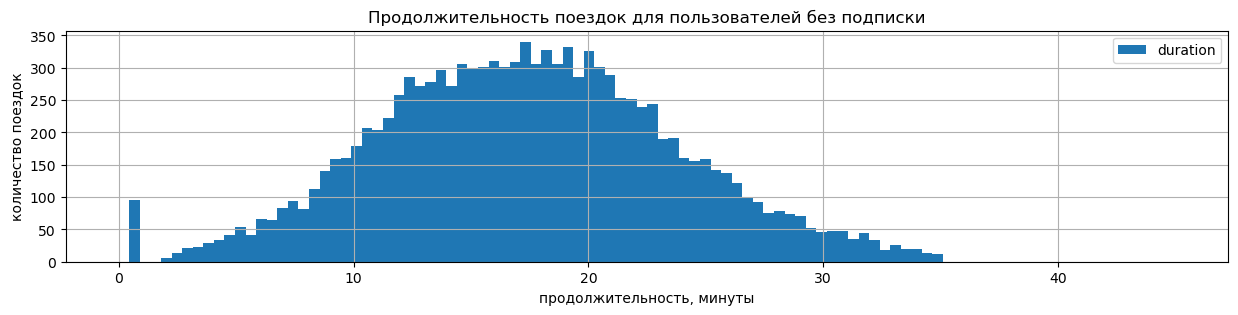

In [70]:
data_users_free.plot(y='duration', kind='hist', bins=100, figsize = (15,3), grid=True, range=(0,45), title='Продолжительность поездок для пользователей без подписки')\
.set(xlabel='продолжительность, минуты', ylabel='количество поездок');

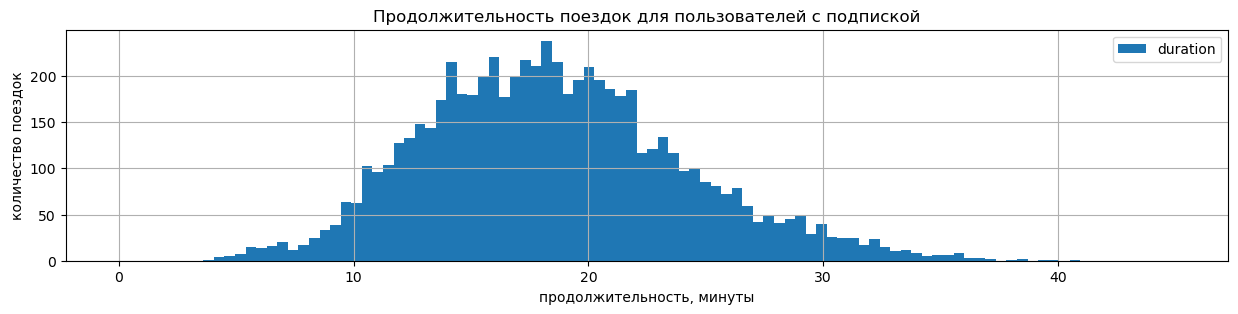

In [71]:
data_users_ultra.plot(y='duration', kind='hist', bins=100, figsize = (15,3), grid=True, range=(0,45), title='Продолжительность поездок для пользователей с подпиской')\
.set(xlabel='продолжительность, минуты', ylabel='количество поездок');

<div style="border: solid pink 2px; padding: 20px">
Формы графиков напоминают общий график для продолжителности поездок.

**Вывод:**
<div style="border: solid pink 2px; padding: 20px">
Количество поездок без подписки (11473) больше, чем поездок с подпиской (6500). Средние расстояния, которое проезжает пользователь за сессию, с подпиской (3115 м) и без (3028 м) схожи, как и среднее время поездки (18 минут для пользователей с подпиской и 17 минут для пользователей без подписки). Пик графика расстояний пользователей без подписки растянут в сторону больших расстояний, пик графика расстояний пользователей с подпиской более выраженный около среднего значения. Графики продолжительности поездок похожи между собой с пиком около среднего значения и похожи на общий график продолжительности поездок.

## Подсчёт выручки

###  Создание датафрейма с агрегированными данными о поездках 

In [72]:
data['duration'] = np.ceil(data['duration'])

In [73]:
data_agg = data.pivot_table(index=['user_id', 'month'],\
values=['distance', 'duration', 'date', 'minute_price', 'start_ride_price', 'subscription_fee'],\
aggfunc={'distance': sum, 'duration': sum, 'date': len, 'minute_price': np.mean, 'start_ride_price': np.mean, 'subscription_fee': np.mean})

In [74]:
data_agg.head()

date     distance  duration  minute_price  start_ride_price  \
user_id month                                                                
1       1         2  7027.511294      42.0             6                 0   
        4         1   754.159807       7.0             6                 0   
        8         2  6723.470560      46.0             6                 0   
        10        2  5809.911100      32.0             6                 0   
        11        3  7003.499363      56.0             6                 0   

               subscription_fee  
user_id month                    
1       1                   199  
        4                   199  
        8                   199  
        10                  199  
        11                  199

### Добавление столбца с помесячной выручкой, которую принёс каждый пользователь

In [75]:
data_agg['month_gain'] = data_agg['start_ride_price']*data_agg['date']+data_agg['duration']*data_agg['minute_price']+data_agg['subscription_fee']

In [76]:
data_agg.head()

date     distance  duration  minute_price  start_ride_price  \
user_id month                                                                
1       1         2  7027.511294      42.0             6                 0   
        4         1   754.159807       7.0             6                 0   
        8         2  6723.470560      46.0             6                 0   
        10        2  5809.911100      32.0             6                 0   
        11        3  7003.499363      56.0             6                 0   

               subscription_fee  month_gain  
user_id month                                
1       1                   199       451.0  
        4                   199       241.0  
        8                   199       475.0  
        10                  199       391.0  
        11                  199       535.0

## Проверка гипотез

### Тратят ли пользователи с подпиской больше времени на поездки?

Cформулируем гипотезы

0. Нулевая гипотеза: средняя продолжительность сессии пользователей с подпиской равна средней продолжительности сессии пользователей без подписки
1. Альтернативная гипотеза: средняя продолжительность сессии пользователей с подпиской больше средней продолжительности сессии пользователей без подписки

In [77]:
alpha = 0.05 
results6_1 = st.ttest_ind(data_users_ultra['duration'], data_users_free['duration'],  alternative='greater')

print('p-значение:', results6_1.pvalue)

if results6_1.pvalue < alpha:
    print('Отвергаем нулевую гипотезу')
else:
    print('Не отвергаем нулевую гипотезу') 

p-значение: 1.2804098316645618e-34
Отвергаем нулевую гипотезу


**Вывод:**
<div style="border: solid pink 2px; padding: 20px">
<u>Нулевая гипотеза</u> о том, что средняя продолжительность сессии пользователей с подпиской равна средней продолжительности сессии пользователей без подписки <b>отвергнута</b>, <u>альтернативная гипотеза</u> о том, что средняя продолжительность сессии пользователей с подпиской больше средней продолжительности сессии пользователей без подписки <b>принимается верной<b>.

### Расстояние, которое проезжают пользователи с подпиской за одну поездку, не превышает 3130 метров?

Cформулируем гипотезы

0. Нулевая гипотеза: среднее расстояние,  которое пользователи с подпиской проезжают за одну поездку равно 3130 метров
1. Альтернативная гипотеза: среднее расстояние,  которое пользователи с подпиской проезжают за одну поездку больше 3130 метров

In [78]:
optimal_distance_value = 3130

alpha = 0.01# уровень статистической значимости

results6_2 = st.ttest_1samp(data_users_ultra['distance'], optimal_distance_value, alternative='greater')

print('p-значение:', results6_2.pvalue)

if (results6_2.pvalue < alpha):
    print('Отвергаем нулевую гипотезу')
else:
    print('Не отвергаем нулевую гипотезу') 

p-значение: 0.9195368847849785
Не отвергаем нулевую гипотезу


**Вывод:**
<div style="border: solid pink 2px; padding: 20px">
<u>Нулевая гипотеза</u> о том, что среднее расстояние, которое пользователи с подпиской проезжают за одну поездку равно 3130 метров <b>принимается верной</b>, <u>альтернативная гипотеза</u> о том, что среднее расстояние, которое пользователи с подпиской проезжают за одну поездку меньше 3130 метров <b>отвергнута<b>.

### Будет ли помесячная выручка от пользователей с подпиской по месяцам выше, чем выручка от пользователей без подписки?

In [79]:
list_user_id_ultra = data_users_ultra['user_id'].unique() # список с user_id пользователей, у которых есть подписка 

In [80]:
data_agg_ultra = data_agg.query('user_id in @list_user_id_ultra') # датафрейм из пользователей с подпиской

In [81]:
data_agg_free = data_agg.query('user_id not in @list_user_id_ultra') # датафрейм из пользователей без подписки

Cформулируем гипотезы

0. Нулевая гипотеза: средняя помесячная выручка от пользователей с подпиской равна средней помесячной выручке от пользователей без подписки
1. Альтернативная гипотеза: средняя помесячная выручка от пользователей с подпиской больше средней помесячной выручке от пользователей без подписки

In [82]:
alpha = 0.05
results6_3 = st.ttest_ind(data_agg_ultra['month_gain'], data_agg_free['month_gain'],  alternative='greater')

print('p-значение:', results6_3.pvalue)

if results6_3.pvalue < alpha:
    print('Отвергаем нулевую гипотезу')
else:
    print('Не отвергаем нулевую гипотезу') 

p-значение: 1.8850394384715216e-31
Отвергаем нулевую гипотезу


**Вывод:**
<div style="border: solid pink 2px; padding: 20px">
<u>Нулевая гипотеза</u> о том, что средняя помесячная выручка от пользователей с подпиской равна средней помесячной выручке от пользователей без подписки <b>отвергнута</b>, <u>альтернативная гипотеза</u> о том, что средняя помесячная выручка от пользователей с подпиской больше средней помесячной выручке от пользователей без подписки <b>принимается верной<b>.

### Какой тест понадобился бы для проверки этой гипотезы о значимом снижении количества обращений в техподдержку?

scipy.stats.ttest_rel(данные о количестве обращений до, данные о количестве обращени после, alternative='less')

## Распределения

### акция с раздачей промокодов 

Известно, что подписку продлевают 10% пользователей, для нашей задачи это 100 клиентов, следовательно 100% клиентов это 1000 клиентов с промокодами. Построим биномиальное распределение

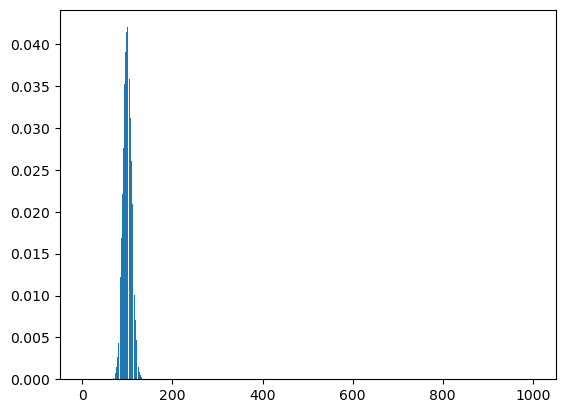

In [83]:
n = 1000 # количество попыток
p = 0.1 # вероятность успеха

distr = []

for k in range(0, n + 1):
    current_value = binom.pmf(k, n, p)
    distr.append(current_value)
    
plt.bar(range(0, n + 1), distr);

In [84]:
binom.cdf(100, 1170, 0.1)

0.051514916737416455

Вероятность не выполнить план в 100 клиентов равна примерно 5% (при условии, что подписку после акции продлевает 10% клиентов) при рассылке 1170 промокодов.

### push-уведомления в мобильном приложении
 

Проверим, можно ли аппроксимировать биномиальное распределение нормальным

In [85]:
# задаём параметры биномиального распределения
n = 1_000_000
p = 0.4


# зададим параметры нормального распределения равными
# мат.ожиданию и дисперсии биномиального распределения
mu = n * p
sigma = sqrt(n * p * (1 - p))
# выводим, выполняется ли наше условие аппроксимации:
# лежит ли mu ± 3 sigma в промежутке от 0 до n:
if (mu - (3 * sigma) >= 0) and ((mu + (3 * sigma) <= n)):
    print('Условие выполняется')
else:
    print('Условие не выполняется')

Условие выполняется


Строим график нормального распределения с параметрами биномиального

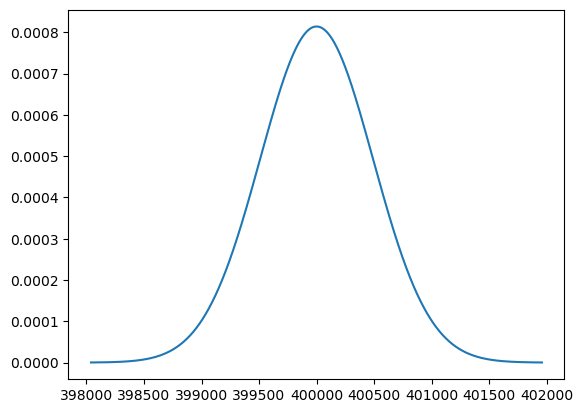

In [86]:
left = int(n * p - 4 * sqrt(n * p * (1 - p)))
right = int(n * p + 4 * sqrt(n * p * (1 - p)))
x = np.arange (left,right, 1)

plt.plot (x, norm. pdf (x, mu, sigma));

In [87]:
st.norm(mu, sigma).cdf(399500) 

0.15371708296369768

Вероятность того, что уведомление откроют не более 399,5 тыс. пользователей составляет 15,4%

## Общий вывод

<div style="border: solid pink 2px; padding: 20px">
    
1. Данные без пропусков с минимальным количеством явных дубликатов.
2. Доля количества пользователей каждого из восьми городов составляет примерно от 10 до 15%, больше всего пользователей из Пятигорска (219 пользователей), меньше - из Москвы (168 пользователей). Количество пользователей без подписки больше (835 пользователей), чем с подпиской (699 пользователей). Средний возраст пользователя - 25 лет. Среднее расстояние, которое проезжает пользователь за одну поездку составляет 3070 м.  Минимальное время поездки составляет около 2 минут, максимальное - 40 минут, среднее - 17 минут . 
    - Выявили поездки, закончившиеся за 30 секунд, с подозрительно большим расстоянием.
3.  Количество поездок без подписки (11473) больше, чем поездок с подпиской (6500). Средние расстояния, которое проезжает пользователь за сессию, с подпиской (3115 м) и без (3028 м) схожи, как и среднее время поездки (18 минут для пользователей с подпиской и 17 минут для пользователей без подписки). 
4. Гипотеза о том, что средняя продолжительность сессии пользователей с подпиской больше средней продолжительности сессии пользователей без подписки не отвегнута.
5. Гипотеза о том, что среднее расстояние, которое пользователи с подпиской проезжают за одну поездку равно 3130 метров не отвргнута.
6. Гипотеза о том, что средняя помесячная выручка от пользователей с подпиской больше средней помесячной выручке от пользователей без подписки не отвергнута.
    
Рекомендации:

- Не смотря на большее количество поездок без подписки, пользователи с подпиской приносят большую среднюю помесячную выручку, чем пользователи без нее. Стоит обратить на это внимание и привлечь еще больше пользователей с подпиской ultra.